In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
%load_ext autoreload
%autoreload 2

In [2]:
print('version:', tf.__version__, '\t\tgpu available:', tf.test.is_gpu_available())

version: 2.0.0 		gpu available: True


# Read Data
- all datasets are datetime sorted

In [4]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
data_path = '../datasets/'

## Amazon Fashion 

In [5]:
# file_name = 'Amazon_full' 
# file_name = 'Amazon_05_users' 
# file_name = 'Amazon_01_users'
# file_name = 'Amazon_005_users'
# file_name = 'Amazon_001_users'

## MovieLens 

In [6]:
# file_name = 'ML_full' 
# file_name = 'ML_05_users'
file_name = 'ML_01_users'
# file_name = 'ML_005_users'
# file_name = 'ML_001_users'

In [7]:
df = pd.read_pickle(data_path + file_name)
df.head()

,user,item,rating,datetime,item_id,user_id
18590190,120461,2501,5.0,2000-04-25 02:29:35,2410,120460
18590032,120461,252,4.0,2000-04-25 02:29:35,249,120460
18590159,120461,2069,4.0,2000-04-25 02:29:35,1980,120460
18590048,120461,440,4.0,2000-04-25 02:29:35,435,120460
18590145,120461,1959,4.0,2000-04-25 02:29:35,1870,120460


# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [8]:
BATCH_SIZE = 64
val_perc = test_perc = 0.1
n_last_items_val = n_last_items_test = 1
learning_rate = 0.1

## Train Test Split

In [9]:
from Data_prep import train_val_test_split

# Train Test Val Split
total_users, total_items, train_set, val_set, test_set = \
train_val_test_split(df, BATCH_SIZE, val_perc, test_perc, n_last_items_val, n_last_items_test)

Total number of items: 27387
Total users: 16254
Number of train users: 16192
Number of test users: 1664
Number of validation users: 1664 

Users deleted: 62


## Option 1: Variable Sequence Length

In [9]:
max_seq_len = 30
min_seq_len = 10
shift_targets_by = 1

In [10]:
from Data_prep import get_x_y_sequences, min_padding
vsl = True # Set for training later

# Train Set
user_sequences_x, user_sequences_y, user_order = get_x_y_sequences(train_set, shift_targets_by)
padded_sequences_x = min_padding(user_sequences_x, BATCH_SIZE, min_seq_len, max_seq_len)
padded_sequences_y = min_padding(user_sequences_y, BATCH_SIZE, min_seq_len, max_seq_len)

# Val Set 
user_sequences_val_x, user_sequences_val_y, user_order = get_x_y_sequences(val_set, shift_targets_by, stats=False)
padded_sequences_val_x = min_padding(user_sequences_val_x, BATCH_SIZE, min_seq_len, max_seq_len)
padded_sequences_val_y = min_padding(user_sequences_val_y, BATCH_SIZE, min_seq_len, max_seq_len)

Number of sequences x: 16192 
Avg sequence length x: 150.41637845849803 
Std_dev sequence length x: 242.74 
Median of sequence length x: 71.0


## Option 2: Fixed Sequence Length

In [10]:
# max_seq_len = 71 #median
# max_seq_len = 142 #2xmedian
max_seq_len = 213 #3xmedian
max_seq_len = 30
shift_targets_by = 1

In [11]:
from Data_prep import get_x_y_sequences, standard_padding
vsl = False

#Train Set
user_sequences_x, user_sequences_y, median = get_x_y_sequences(train_set, shift_targets_by, ordered=False)
sequences_data_x = standard_padding(user_sequences_x, max_seq_len)
sequences_data_y = standard_padding(user_sequences_y, max_seq_len, stats=False)

dataset = tf.data.Dataset.zip((sequences_data_x, sequences_data_y))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)

#Val Set
user_sequences_val_x, user_sequences_val_y, median = get_x_y_sequences(val_set, shift_targets_by, ordered=False, stats=False)
sequences_data_val_x = standard_padding(user_sequences_val_x, max_seq_len, stats=False)
sequences_data_val_y = standard_padding(user_sequences_val_y, max_seq_len, stats=False)

val_dataset = tf.data.Dataset.zip((sequences_data_val_x, sequences_data_val_y))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)

Number of sequences x: 16192 
Avg sequence length x: 150.41637845849803 
Std_dev sequence length x: 242.74 
Median of sequence length x: 71.0
number of sequences: 16192 
avg sequence length: 30.0 
std_dev sequence length: 0.0


---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks
- paper: https://arxiv.org/pdf/1608.07400.pdf
- code: https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Architecture

In [46]:
def build_model(total_items, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(total_items, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        
        tf.keras.layers.LSTM(units=rnn_units,
                             return_sequences=True,
                             stateful=False, #Reset cell states with each batch
                             recurrent_initializer='glorot_uniform'),
        
        tf.keras.layers.Dense(total_items)
    ])
    return model

## Build Model

In [36]:
embedding_dim = 100
rnn_units = 20

In [37]:
model = build_model(
total_items = total_items,
embedding_dim = embedding_dim,
rnn_units = rnn_units,
batch_size = BATCH_SIZE)

## Add Loss
- **Added one hot encoding of the labels to match logits output after dense layer**

In [14]:
def recall(y_true, y_pred):
    K = tf.keras.backend
    y_true = K.one_hot(tf.dtypes.cast(y_true, tf.int32), total_items)
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

In [15]:
def loss(labels, logits):
    oh_labels = tf.keras.backend.one_hot(tf.dtypes.cast(labels, tf.int32), total_items)
    return tf.keras.losses.categorical_crossentropy(oh_labels, logits, from_logits=True)

In [16]:
optimizer = tf.keras.optimizers.Adagrad(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=[recall])

In [17]:
optimizer

## Summmary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 100)           2738700   
_________________________________________________________________
lstm (LSTM)                  (64, None, 20)            9680      
_________________________________________________________________
dense (Dense)                (64, None, 27387)         575127    
Total params: 3,323,507
Trainable params: 3,323,507
Non-trainable params: 0
_________________________________________________________________


---
# Train Model

### Configure Checkpoints

In [25]:
# Directory where the checkpoints will be saved
if vsl:
    checkpoint_dir = '../ckpts/ckpts_vsl' + file_name + '_lr' + str(learning_rate)
else:
    checkpoint_dir = '../ckpts/ckpts_fixed_' + str(max_seq_len) + file_name + '_lr' + str(learning_rate)
    
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only = True)

## Fit Model

In [20]:
epochs = 150
print('#Batches:', len(user_sequences_x)/BATCH_SIZE)
print('Batch size:', BATCH_SIZE)

#Batches: 253.0
Batch size: 64


In [21]:
if vsl:
    print('Fitting LSTM with Variable sequence length')
    from Helpers import Batch_Generator
    history = model.fit_generator(generator=Batch_Generator(
                                  X=padded_sequences_x, 
                                  y=padded_sequences_y, 
                                  batch_size=BATCH_SIZE,
                                  shuffle=True),

    #                               validation_data=Batch_Generator(
    #                               X=padded_sequences_val_x,
    #                               y=padded_sequences_val_y,
    #                               batch_size=BATCH_SIZE,
    #                               shuffle=True),

                                  epochs=epochs, 
                                  callbacks=[checkpoint_callback],
                                  use_multiprocessing=True)
else:
    print('Fitting LSTM with Fixed sequence length:', str(max_seq_len))
    history = model.fit(dataset, 
                        validation_data=val_dataset, 
                        epochs=epochs, 
                        callbacks=[checkpoint_callback])

Fitting LSTM with Fixed sequence length: 30
Epoch 1/150
253/253 [==============================] - 17s 68ms/step - loss: 9.9502 - recall: 6.8501e-04 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
253/253 [==============================] - 13s 52ms/step - loss: 9.2718 - recall: 0.0153 - val_loss: 3.1295 - val_recall: 0.0271
Epoch 3/150
253/253 [==============================] - 13s 53ms/step - loss: 8.7411 - recall: 0.0354 - val_loss: 3.1391 - val_recall: 0.0436
Epoch 4/150
253/253 [==============================] - 13s 53ms/step - loss: 8.4752 - recall: 0.0496 - val_loss: 3.1283 - val_recall: 0.0560
Epoch 5/150
253/253 [==============================] - 13s 52ms/step - loss: 8.3241 - recall: 0.0595 - val_loss: 3.1188 - val_recall: 0.0642
Epoch 6/150
253/253 [==============================] - 13s 52ms/step - loss: 8.2260 - recall: 0.0677 - val_loss: 3.1113 - val_recall: 0.0720
Epoch 7/150
253/253 [==============================] - 13s 52ms/step - loss: 8.1571 - recall: 0.07

In [22]:
file_name

'ML_01_users'

In [23]:
results = pd.DataFrame(history.history)
if vsl:
    results.to_pickle('../results/his_vsl_01_ml_users_100_epochs' + '_lr' + str(learning_rate))
else:
    results.to_pickle('../results/his_fixed_' + str(max_seq_len) + '_01_ml_users_100_epochs' + '_lr' + str(learning_rate))

In [12]:
res = pd.DataFrame(pd.read_pickle('../results/his_fixed_' + str(max_seq_len) + '_01_ml_users_100_epochs' + '_lr' + str(learning_rate)))

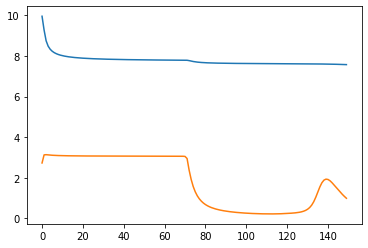

In [13]:
plt.plot(res['loss'])
plt.plot(res['val_loss'])
plt.show()

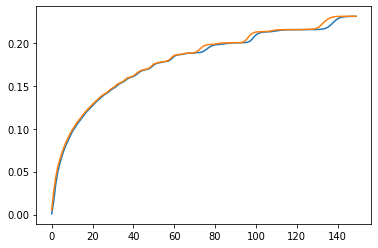

In [14]:
plt.plot(res['recall'])
plt.plot(res['val_recall'])
plt.show()

---
## Continue training from checkpoint

In [15]:
# model.summary()

In [16]:
# tf.train.latest_checkpoint(checkpoint_dir)
# model = build_model(total_items, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
# model.compile(optimizer=optimizer, loss=loss, metrics=[recall])

In [17]:
# aditional_epochs = 50

In [18]:
# model.fit(dataset, validation_data=val_dataset, epochs=aditional_epochs, callbacks=[checkpoint_callback])

---
# Predict Sequences

## Restore Latest Checkpoints
- **TODO: Can keep batches of 64 for evaluation => faster**

In [31]:
tf.train.latest_checkpoint(checkpoint_dir)

'../ckpts/ckpts_fixed_30ML_01_users_lr0.1/ckpt'

In [19]:
def get_predictions(model, train_set, test_set, rank_at, temp=1):
    """
    Uses a Keras model with batch size set to 1 to predict the rest of the sequences from the train_set per user
    finally puts user, a list pred_items_ranked and a list containing true_ids from the test set
    :param model: Keras RNN model with batch size set to 1
    :param train_set: pandas df containing user_id, item_id sorted on datetime per user
    :param test_set: pandas df containing: user_id, last item_id(s) per user
    :param rank_at: maximum of top ranked items per user
    :param temp: temperature, 1 means no deviation from model prediction
    :return: pandas df where each row represents a user, the columns represent: pred_items_ranked at rank_at,
             true_id extracted from test_set
    """
    predictions_df = pd.DataFrame(columns=['user', 'pred_items_ranked', 'true_id'])
    for u in test_set.user_id.unique():
        test_user_seq = np.array(train_set[train_set['user_id'] == u]['item_id'])
        true_items = list(test_set[test_set['user_id'] == u]['item_id'])
        generated_predictions = []

        # Predict
        for item in range(rank_at):  # could be any number of recommended items you want to predict
            predictions = model(test_user_seq.reshape(-1, 1).T)
            predictions = tf.squeeze(predictions, 0)

            predictions = predictions / temp
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
            test_user_seq = np.append(test_user_seq, predicted_id).reshape(-1, 1).transpose()

            #         half_test_seq = tf.expand_dims([predicted_id], 0)
            generated_predictions.append(predicted_id)

        predictions_df = predictions_df.append(
            {'user': u, 'pred_items_ranked': generated_predictions, 'true_id': true_items}, ignore_index=True)

    return predictions_df

In [28]:
u = 10278
test_user_seq = np.array(train_set[train_set['user_id'] == u]['item_id'])
true_items = list(test_set[test_set['user_id'] == u]['item_id'])

In [29]:
new_test_set = train_set[train_set.user_id.isin(test_set.user_id.unique())].groupby('user_id')['item_id'].apply(list)

In [87]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, 3, 1))
x_input

array([[[70],
        [80],
        [90]]])

In [104]:
len(new_test_set.iloc[4])

200

In [166]:
sequence = new_test_set.iloc[5]

In [173]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [174]:
predictions = []
pred_item_id = model.predict(np.array([sequence,])).argmax()
predictions

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[0,250] = 410805 is not in [0, 27387)
	 [[node embedding_4/embedding_lookup (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1751) ]]
	 [[embedding_4/embedding_lookup/_6]]
  (1) Invalid argument:  indices[0,250] = 410805 is not in [0, 27387)
	 [[node embedding_4/embedding_lookup (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1751) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_7267]

Function call stack:
keras_scratch_graph -> keras_scratch_graph


In [136]:
sequence = new_test_set.iloc[16]
tf.random.categorical(model.predict(np.array([sequence,])), 1)

InvalidArgumentError: logits should be a matrix, got shape [1,23,27387] [Op:Multinomial]

In [89]:
predictions = []
sequence = new_test_set.iloc[1] 
for i in range(20):
    pred_item_id = model.predict(np.array([sequence,])).argmax()
    predictions.append(pred_item_id)
    sequence.append(pred_item_id)
predictions

[348, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [54]:
yhat = model.predict(new_test_set.iloc[3], verbose=0)

In [57]:
len(yhat)

796

In [95]:
total_items

27387

In [108]:
model.predict()

array([[[ 6.5579305 ,  4.195658  ,  3.8592424 , ..., -0.4317268 ,
         -0.43991497, -0.42959884]],

       [[ 6.646965  ,  4.200689  ,  3.8638463 , ..., -0.43216455,
         -0.44044372, -0.43007022]],

       [[ 6.865742  ,  4.2183046 ,  3.8801608 , ..., -0.43373075,
         -0.44208387, -0.43189982]],

       ...,

       [[ 6.409998  ,  4.181034  ,  3.8457491 , ..., -0.4303646 ,
         -0.4385426 , -0.42813313]],

       [[ 8.562332  ,  4.3772454 ,  4.027392  , ..., -0.44853246,
         -0.45810473, -0.44862837]],

       [[ 8.53319   ,  4.3581448 ,  4.009252  , ..., -0.44650066,
         -0.45612025, -0.44668055]]], dtype=float32)

In [47]:
preds = model(test_user_seq.reshape(-1, 1).T)
preds = tf.squeeze(preds, 0 )
preds

81

In [115]:
model = build_model(total_items, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [116]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 100)            2738700   
_________________________________________________________________
lstm_4 (LSTM)                (1, None, 20)             9680      
_________________________________________________________________
dense_4 (Dense)              (1, None, 27387)          575127    
Total params: 3,323,507
Trainable params: 3,323,507
Non-trainable params: 0
_________________________________________________________________


## Create Predictions
- **TODO: Can keep batches of 64 for evaluation => faster**

Using train_set sequences to predict test_set / val_set item(s)

In [31]:
from Evaluation import get_predictions

In [32]:
file_name

'ML_01_users'

### Val Set Predictions

In [33]:
rank_at = 20
preds_val = get_predictions(model, train_set, val_set, rank_at)
preds_val.to_pickle('../results/preds_val_CFRNN_vsl_100_' + file_name + '_lr' + str(learning_rate))

### Fixed

In [33]:
rank_at = 20
preds_val = get_predictions(model, train_set, val_set, rank_at)
preds_val.to_pickle('../results/preds_val_CFRNN_fixed_100_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

### Test Set Predictions

In [34]:
rank_at = 20
preds_test = get_predictions(model, train_set, test_set, rank_at)
preds_test.to_pickle('../results/preds_test_CFRNN_vsl_100_' + file_name + '_lr' + str(learning_rate))

### Fixed

In [34]:
rank_at = 20
preds_test = get_predictions(model, train_set, test_set, rank_at)
preds_test.to_pickle('../results/preds_test_CFRNN_fixed_100_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

#### Read Predictions

In [55]:
# predictions = pd.read_pickle('CFRNN_res_200_ML_01_users')

---
# Evaluate

In [35]:
from Evaluation import get_metrics

### Val Set Metrics

In [36]:
metrics_val_set_vsl = get_metrics(preds_val, 5, 20)
metrics_val_set_vsl

Obtaining metrics time: 1.12


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,8,0.004808,0.000962
2,10,15,0.009014,0.000901
3,15,21,0.012620,0.000841
4,20,27,0.016226,0.000811


In [37]:
metrics_val_set_vsl.to_pickle('../results/metrics_val_CFRNN_fixed_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

In [37]:
metrics_val_set_vsl.to_pickle('../results/metrics_val_CFRNN_vsl_' + file_name + '_lr' + str(learning_rate))

### Test Set Metrics

In [38]:
metrics_test_set_vsl = get_metrics(preds_test, 5, 20)
metrics_test_set_vsl

Obtaining metrics time: 1.13


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,4,0.002404,0.000481
2,10,8,0.004808,0.000481
3,15,12,0.007212,0.000481
4,20,19,0.011418,0.000571


In [39]:
metrics_test_set_vsl.to_pickle('../results/metrics_test_CFRNN_fixed_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

In [39]:
metrics_test_set_vsl.to_pickle('../results/metrics_test_CFRNN_vsl_' + file_name + '_lr' + str(learning_rate))

# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)

In [ ]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 